<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [3]:
from scipy.linalg import sqrtm
!pip install ydata_profiling

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\mifmi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from ydata_profiling import ProfileReport
import re
from phik import phik_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
import warnings
import pickle


random.seed(42)
np.random.seed(42)

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

Сиды фиксируем для воспроизводимости результатов

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [5]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [6]:
print('Пропуски в Train\n', df_train.isna().sum(), '\n')
print('Пропуски в Test\n', df_test.isna().sum(), '\n')

Пропуски в Train
 name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          202
engine           202
max_power        196
torque           203
seats            202
dtype: int64 

Пропуски в Test
 name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage          19
engine           19
max_power        19
torque           19
seats            19
dtype: int64 



- Есть пропущенные значения в колонках: mileage, engine, max_power, torque, seats


In [7]:
print('Дубликаты в Train\n', df_train.duplicated().sum(), '\n')
print('Дубликаты в Test\n', df_test.duplicated().sum(), '\n')

Дубликаты в Train
 985 

Дубликаты в Test
 62 



In [8]:
profile = ProfileReport(df_train, explorative=True)
profile

ModuleNotFoundError: No module named 'ipywidgets'

- Достаточно много дубликатов
- Пропуски есть, но не так много
- Имеются сильные корреляции: km_driven - year, selling_price - km_driven, selling_price - year, selling_price - transmission
- В fuel доминируют значения "Diesel" и "Petrol"
- В seller_type доминируют "Individual"
- Есть асимметрия в числовых признаках - продаются в основном машины с 2010 г. с небольшим пробегом и ценой до 100.000
- Есть выбросы в пробеге km_driven и в цене selling_price


### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутствие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [9]:
print('TRAIN STAT\n', df_train.describe(include=['int64', 'float64']), '\n')
print('TEST STAT\n', df_test.describe(include=['int64', 'float64']), '\n')

print('TRAIN STAT\n', df_train.describe(include=['object']).T, '\n')
print('STAT STAT\n', df_test.describe(include=['object']).T, '\n')

TRAIN STAT
               year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000 

TEST STAT
               year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000

**Выводы:**
- Статистики у train и test имеют примерно схожее распределение, что хорошо.
- Медиана по year больше среднего в обоих случаях. Есть небольшая асимметрия - машин постарее побольше.
- Среднее по selling_price значительно больше медианы в обоих случаях. Правая асимметрия - есть большие цены, которые тянут за собой среднюю цену.
- То же самое можно сказать о km_driven. Правая асимметрия - большие пробеги тянут за собой среднее значение.
- По seats - в основном все пятиместные, но есть малое количество предложений с бОльшим количеством мест.

**Держать в голове:**
- Есть выбросы по selling_price и km_driven.
- Возможность применения логарифмической трансформации, чтобы уменьшить асимметрию.

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [10]:
similar = df_train.duplicated(subset=df_train.columns.drop('selling_price'), keep=False) # keep=False - чтобы взять все одинаковые объекты, а не только повторы

print('Количество объектов с одинаковым признаковым описанием:\n', similar.sum(), '\n')
print('Объекты с одинаковым признаковым описанием:\n', df_train[similar], '\n')

Количество объектов с одинаковым признаковым описанием:
 1799 

Объекты с одинаковым признаковым описанием:
                                           name  year  selling_price  \
22                     Maruti Baleno Delta 1.2  2016         575000   
26                 Maruti Omni E MPI STD BS IV  2018         254999   
27             Maruti Vitara Brezza LDi Option  2017         670000   
28                          Fiat Palio 1.2 ELX  2003          70000   
29                   Maruti Omni 8 Seater BSIV  2012         150000   
...                                        ...   ...            ...   
6981  Ford Freestyle Titanium Plus Diesel BSIV  2018         750000   
6984  Ford Freestyle Titanium Plus Diesel BSIV  2018         746000   
6989                    Maruti Swift Dzire VDI  2015         625000   
6997                           Tata Indigo CR4  2013         290000   
6998                           Tata Indigo CR4  2013         290000   

      km_driven    fuel seller_type tr

In [11]:
# Удаление дублей и сброс индексов
df_train = df_train.drop_duplicates(subset=df_train.columns.drop('selling_price'), keep='first', ignore_index=True).copy()
df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92 kmpl,1086 CC,62.1 bhp,96.1Nm@ 3000rpm,5.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0


In [12]:
copy_train = df_train.copy().drop(columns=['selling_price'])

# Скрытые дубли 1. Приведение текстовых полей в один регистр и удаление пробелов по бокам (если есть)

for column in copy_train.describe(include=['object']).columns:
    copy_train[column] = copy_train[column].str.lower().str.strip()

print("(1) Повторов:", copy_train.duplicated(keep=False).sum())

# Скрытые дубли 2. Слова могут быть переставлены, поэтому можно их отсортировать

for column in copy_train.describe(include=['object']).columns:
    copy_train[column] = copy_train[column].apply(lambda x: " ".join(sorted(str(x).split())))

print("(2) Повторов:", copy_train.duplicated(keep=False).sum())

# * Какие-то значения могут отличаться на доли процента, но это очень затратный поиск из всех данных для каждого объекта.

copy_train

(1) Повторов: 0
(2) Повторов: 0


,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,dzire maruti swift vdi,2014,145500,diesel,individual,manual,first owner,23.4 kmpl,1248 cc,74 bhp,190nm@ 2000rpm,5.0
1,1.5 ambition rapid skoda tdi,2014,120000,diesel,individual,manual,owner second,21.14 kmpl,1498 cc,103.52 bhp,1500-2500rpm 250nm@,5.0
2,diesel hyundai i20 sportz,2010,127000,diesel,individual,manual,first owner,23.0 kmpl,1396 cc,90 bhp,1750-2750rpm 22.4 at kgm,5.0
3,bsiii maruti swift vxi,2007,120000,petrol,individual,manual,first owner,16.1 kmpl,1298 cc,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,1.2 e hyundai plus vtvt xcent,2017,45000,petrol,individual,manual,first owner,20.14 kmpl,1197 cc,81.86 bhp,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5835,gls hyundai santro xing,2008,191000,petrol,individual,manual,first owner,17.92 kmpl,1086 cc,62.1 bhp,3000rpm 96.1nm@,5.0
5836,abs bs iv maruti r vxi wagon with,2013,50000,petrol,individual,manual,owner second,18.9 kmpl,998 cc,67.1 bhp,3500rpm 90nm@,5.0
5837,hyundai i20 magna,2013,110000,petrol,individual,manual,first owner,18.5 kmpl,1197 cc,82.85 bhp,113.7nm@ 4000rpm,5.0
5838,crdi hyundai sx verna,2007,119000,diesel,individual,manual,& above fourth owner,16.8 kmpl,1493 cc,110 bhp,"1,900-2,750(kgm@ 24@ rpm)",5.0


### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [13]:
columns = ['mileage', 'engine', 'max_power']

# Узнаем какие существуют единицы измерения
values = {}
for column in columns:
    values[column] = []
    for val in df_train[column]:
        try:
            x, y = str(val).split()
            if not y in values[column]:
                values[column].append(y)
        except ValueError:
            pass
    for val in df_test[column]:
        try:
            x, y = str(val).split()
            if not y in values[column]:
                values[column].append(y)
        except ValueError:
            pass

print(values)
# Получаем два значения 'kmpl', 'km/kg', т.е. километры на литр топлива или километры килограмм газа. Будем считать что это примерно одно и то же, чтобы не делать преобразования.
# В остальном всё нормально.

# Приведение к float
for column in columns:
    # Извлекаем последовательность цифр и точек через регулярку
    df_train[column] = df_train[column].str.extract(r"([\d\.]+)").astype(float)
    df_test[column] = df_test[column].str.extract(r"([\d\.]+)").astype(float)


{'mileage': ['kmpl', 'km/kg'], 'engine': ['CC'], 'max_power': ['bhp']}


In [14]:
# Предобработка torque
def parser(text):
    if not isinstance(text, str):
        return None, None
    text = text.lower()
    numbers = [float(num) for num in re.findall(r"\d+\.?\d*", text.replace(",", ""))]
    # Если три числа, то первые два - это диапазон rpm. Берем макс.
    if len(numbers) == 3:
        rpm = numbers[2]
        torque = numbers[0]
    # Если два - уже смотрим на порядок
    elif len(numbers) == 2:
        i_torque = abs(text.find("kgm") * text.find("nm")) # либо-либо
        i_rpm = text.find("rpm")
        if i_rpm != -1 and i_rpm < i_torque:
            rpm = numbers[0]
            torque = numbers[1]
        else:
            rpm = numbers[1]
            torque = numbers[0]
    else:
         return None, None
    # Если torque в kgm, то переводим в nm
    if not "nm" in text and "kgm" in text:
        torque = torque * 9.81
    return float(torque), int(rpm)

df_train[['torque', 'max_torque_rpm']] = df_train['torque'].apply(lambda x: pd.Series(parser(x)))
df_test[['torque', 'max_torque_rpm']] = df_test['torque'].apply(lambda x: pd.Series(parser(x)))


print(df_train.describe(), '\n')

              year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5654.000000  5654.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.432842  1435.418111   
std       4.095622   5.354320e+05  6.007114e+04     4.051002   492.453262   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.800000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.320000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque       seats  max_torque_rpm  
count  5656.000000  5650.000000  5654.00000     5650.000000  
mean     88.103070   175.751852     5.44075     3041.311150  
std      32.131943   108.789334     0.99527      931.579391  
min       0.000000    47.088000     2.00000      500.00000

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






**Ответы:**
- Применяем медианту, т.к. она устойчива к выбросам, которые у нас как раз есть. Среднее можно применять, когда нет асимметрии.
- Медиану надо считать только по df_train, а затем заполнять ею пропуски в df_test. В test не лезим и ничего не считаем, чтобы не было утечки данных.

In [15]:
print(df_train.describe(include=['int64', 'float64']), '\n\n')

columns = ['mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']

# Рассчитываем медианы
medians = df_train[columns].median()

# Заполняем пропуски
df_train[columns] = df_train[columns].fillna(medians)
df_test[columns] = df_test[columns].fillna(medians)

print(df_train.isnull().sum(), "\n", df_test.isnull().sum())

              year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5654.000000  5654.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.432842  1435.418111   
std       4.095622   5.354320e+05  6.007114e+04     4.051002   492.453262   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.800000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.320000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque       seats  max_torque_rpm  
count  5656.000000  5650.000000  5654.00000     5650.000000  
mean     88.103070   175.751852     5.44075     3041.311150  
std      32.131943   108.789334     0.99527      931.579391  
min       0.000000    47.088000     2.00000      500.00000

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [16]:
columns = ['engine', 'seats']

# Приведение к int
for column in columns:
    df_train[column] = df_train[column].astype(float).round().astype(int)
    df_test[column] = df_test[column].astype(float).round().astype(int)

df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.000,5,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.000,5,2500.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,219.744,5,2750.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,112.815,5,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.750,5,4000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086,62.10,96.100,5,3000.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998,67.10,90.000,5,3500.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197,82.85,113.700,5,4000.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493,110.00,235.440,5,2750.0


- Фичу seats возможно рассмотреть как категориальную переменную, потому что её значения дискретны и сильно ограничены. Можно связать seats с классом автомобиля.

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [17]:
print(df_train.describe(include=['int64', 'float64']), '\n')

              year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque        seats  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000     5840.000000  
mean     87.906371   175.239377     5.426712     3039.967123  
std      31.640418   107.041196     0.982344      916.326648  
min       0.000000    47.088000     2.000000      500.

- Проанализировав полученные результаты, делаю вывод, что распределения практически не поменялись. Средние значения примерно остались теми же.
- Заполнение пропусков медианными значениями, конечно, может менять распределение. Особенно, если пропусков много - медиана будет ярко выражена на графике. Или если есть асимметрия, то она уменьшится и сместится в сторону медианы.

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

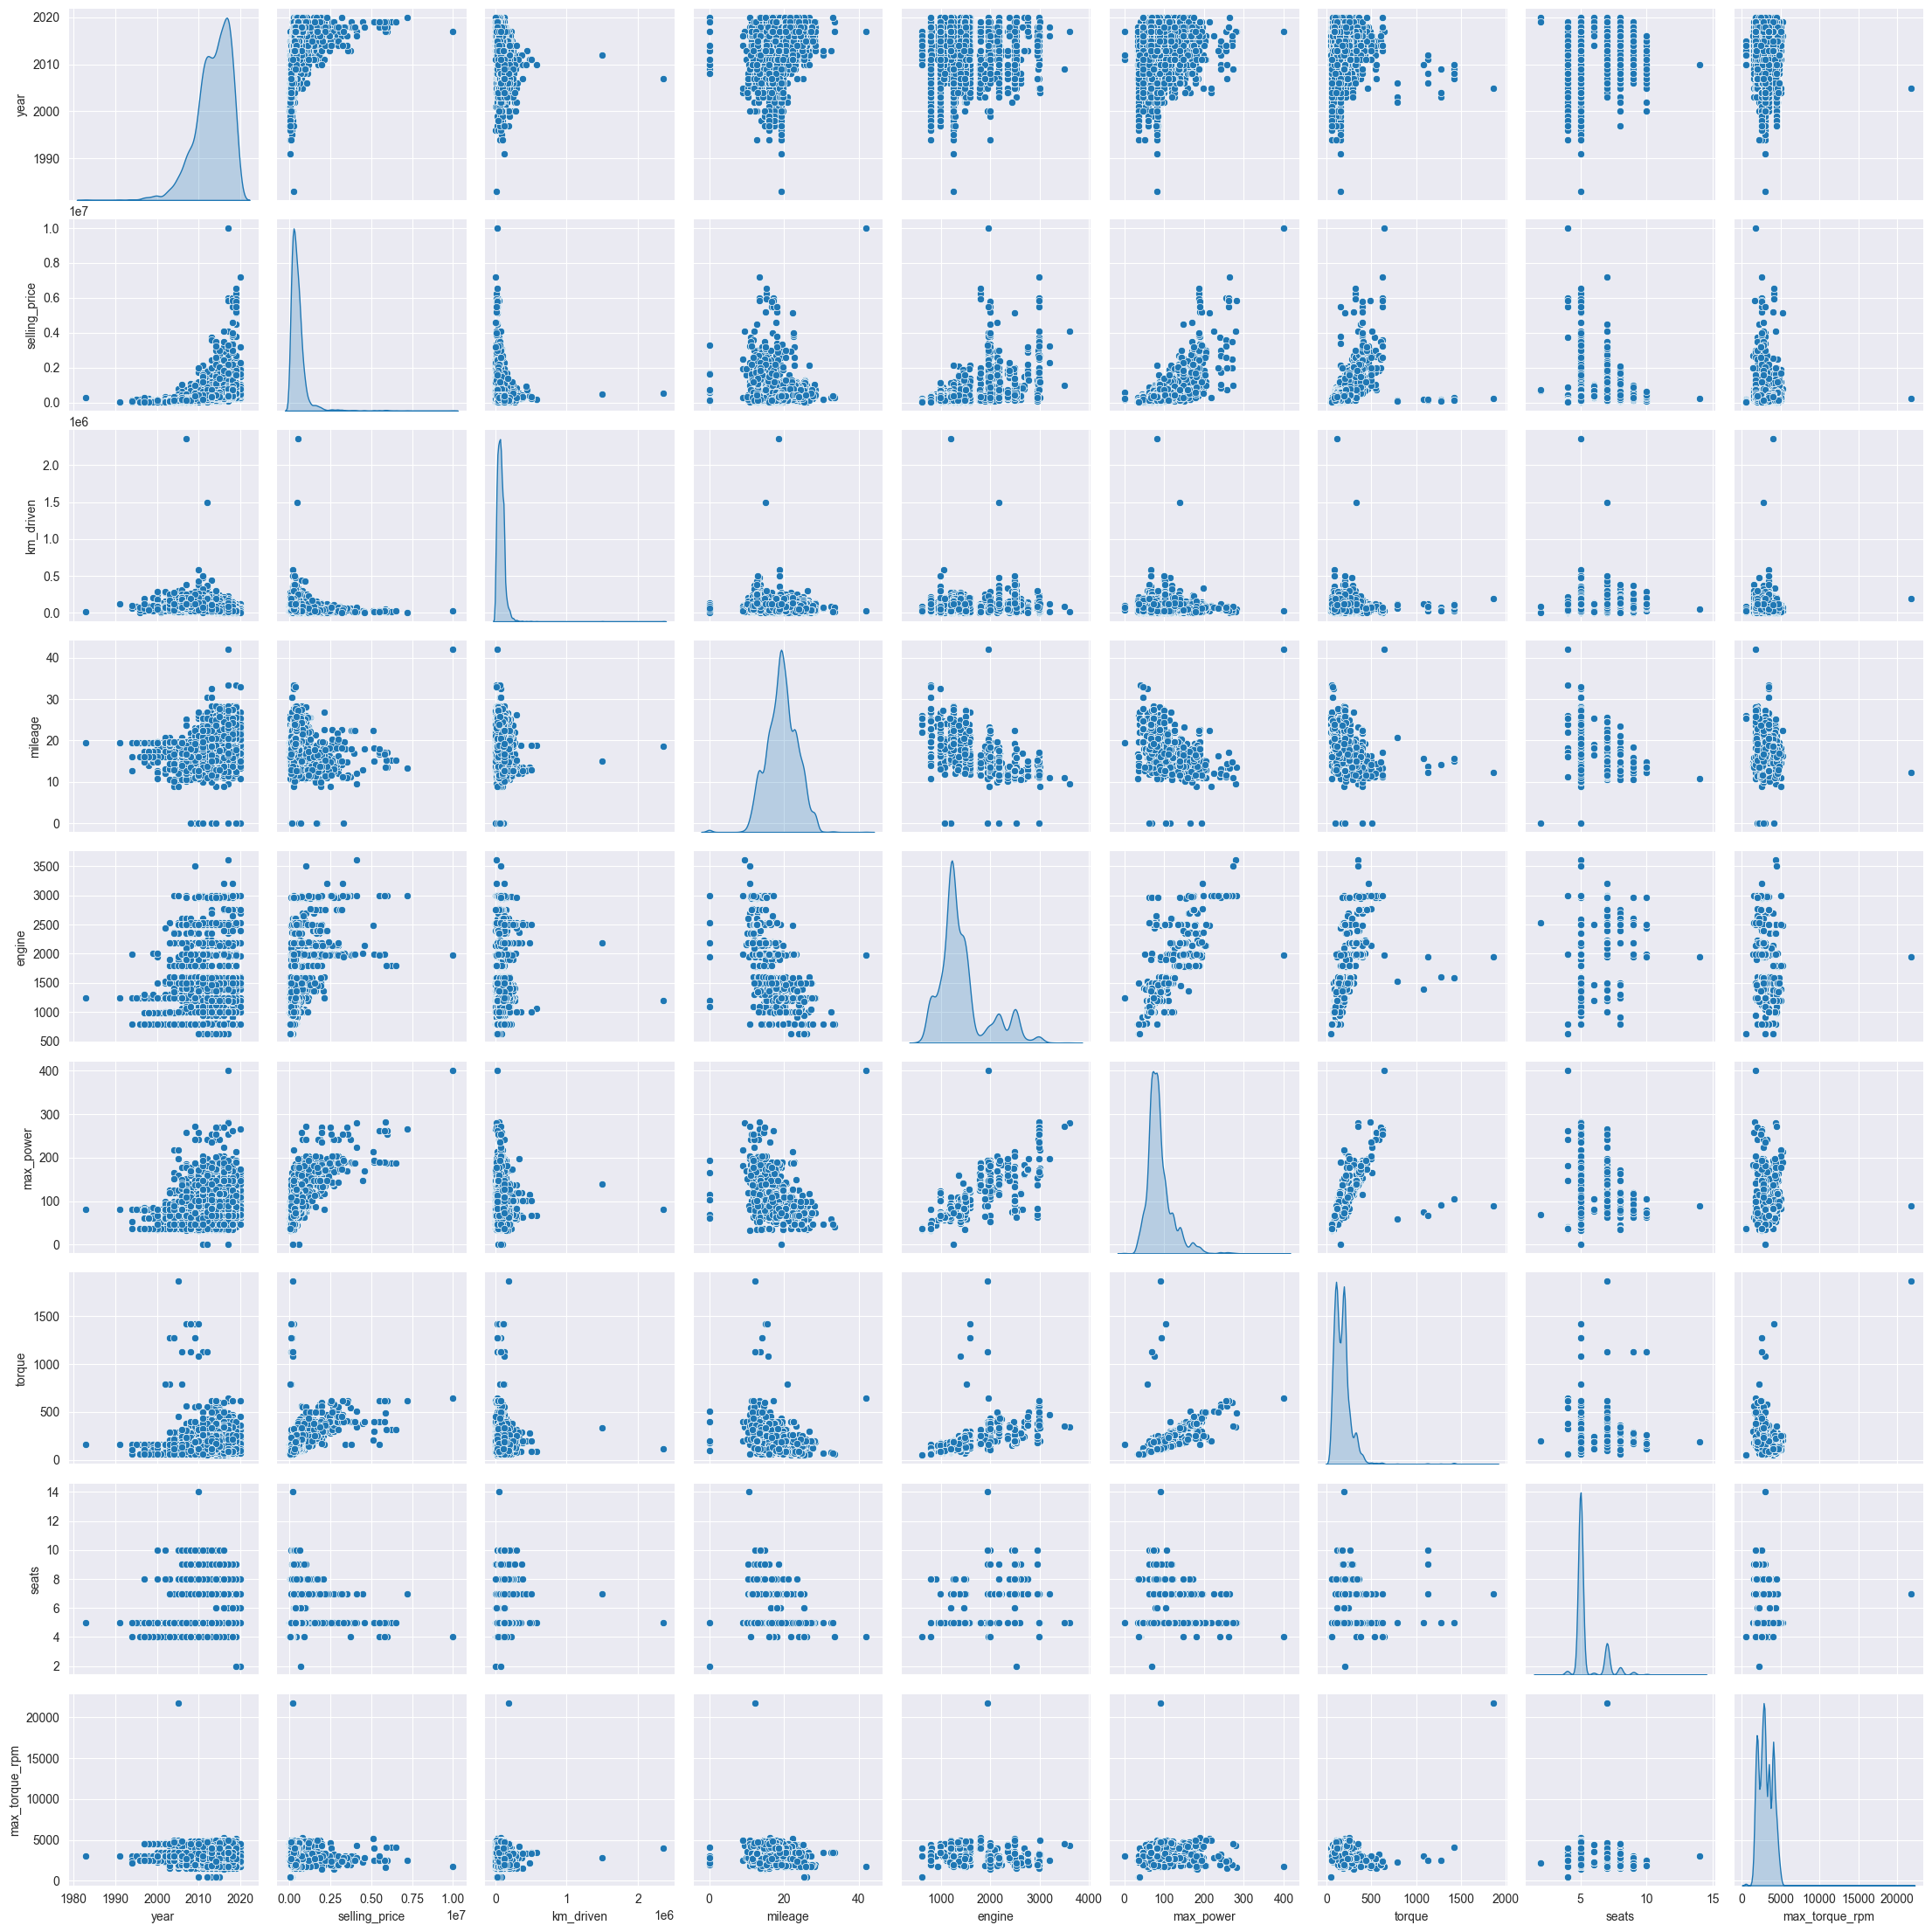

In [18]:
sns.pairplot(df_train[df_train.select_dtypes(include=['int64', 'float64']).columns], diag_kind='kde')
plt.show()

- Можно и логично предположить связь цены: с пробегом (чем больше, тем цена ниже), с годом выпуска (чем новее, тем дороже).
- Можно предположить связь цены и класса автомобиля (по числу мест в нем).
- Есть небольшая зависимость цены от мощности двигателя (и крутящего момента).
- Есть и другие корреляции. Например, чем больше torque, тем больше max_power и объем двигателя, что логично.
- Есть характеристика, которая вообще ни с чем не связана. Например, max_torque_rpm.

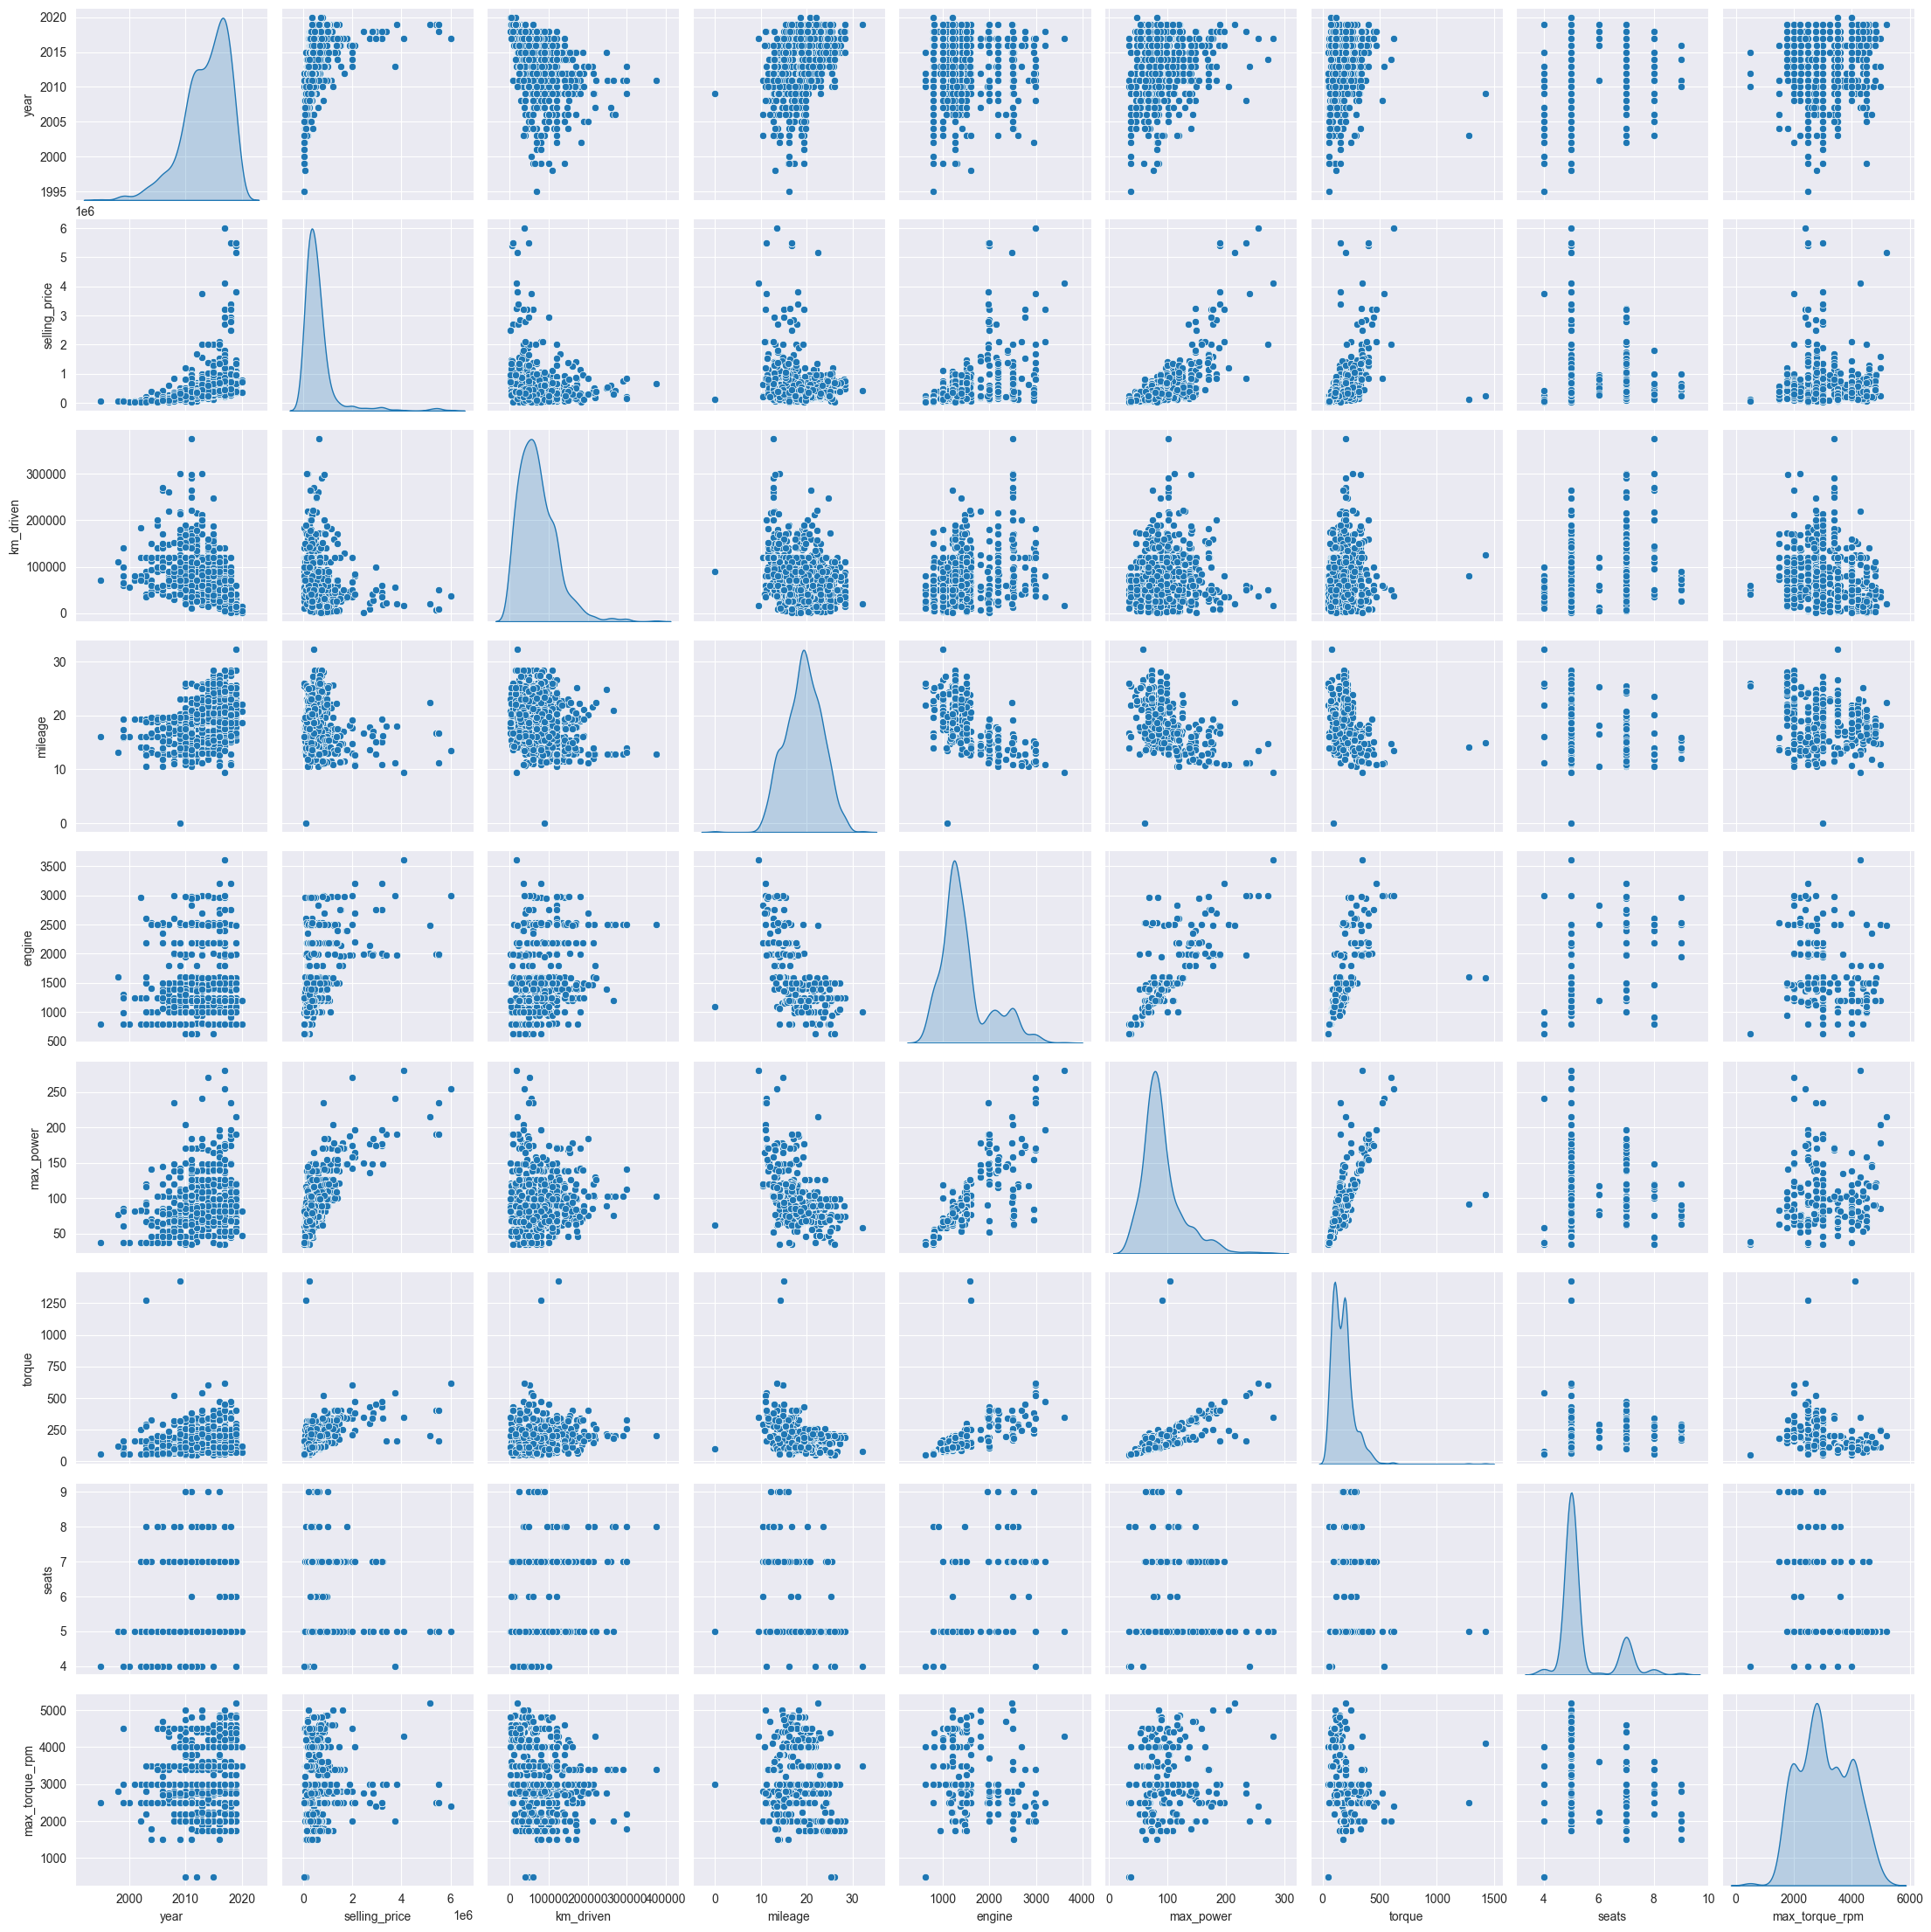

In [19]:
sns.pairplot(df_test[df_test.select_dtypes(include=['int64', 'float64']).columns], diag_kind='kde')
plt.show()

- Распределения train и test оказались похожи.
- Выбросов на тесте значительно меньше, и распределения отрисованы более четко и наглядно.

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [20]:
pearson = df_train.corr(method="pearson", numeric_only=True)
pearson

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.427279,-0.368966,0.341334,0.002819,0.156858,0.051670,0.041178,0.049746
selling_price,0.427279,1.000000,-0.164828,-0.104769,0.447672,0.692814,0.458916,0.149953,-0.082284
km_driven,-0.368966,-0.164828,1.000000,-0.182086,0.229766,0.024588,0.114137,0.192328,-0.199485
mileage,0.341334,-0.104769,-0.182086,1.000000,-0.572893,-0.373390,-0.237481,-0.451059,-0.189613
engine,0.002819,0.447672,0.229766,-0.572893,1.000000,0.681117,0.599403,0.652172,-0.232976
max_power,0.156858,0.692814,0.024588,-0.373390,0.681117,1.000000,0.656901,0.244112,-0.009728
torque,0.051670,0.458916,0.114137,-0.237481,0.599403,0.656901,1.000000,0.317102,-0.259328
seats,0.041178,0.149953,0.192328,-0.451059,0.652172,0.244112,0.317102,1.000000,-0.195842
max_torque_rpm,0.049746,-0.082284,-0.199485,-0.189613,-0.232976,-0.009728,-0.259328,-0.195842,1.000000


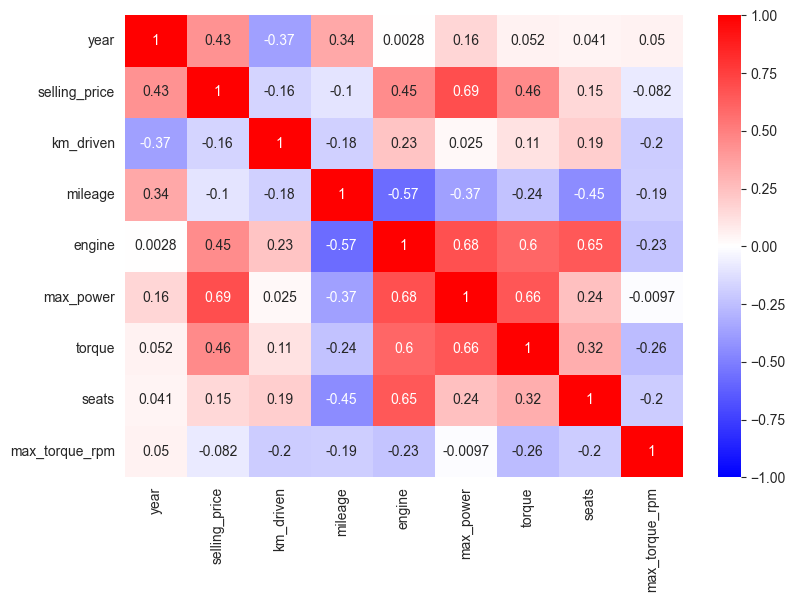

In [21]:
plt.figure(figsize=(9, 6))
sns.heatmap(pearson, annot=True, cmap="bwr", vmin=-1, vmax=1)
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

**Ответы:**
- Наименее скоррелированы между собой year и engine
- Наблюдается довольно сильная положительная линейная зависимость между: selling_price + year, selling_price + max_power, engine + max_power, engine + selling_price, max_power + torque, seats + engine
- Существует отрицательная корреляция года выпуска и пробега: чем меньше год (старше машина) тем больше пробег.
- Я использовал Pearson. Можно выбрать ещё Kendall или Spearman.

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


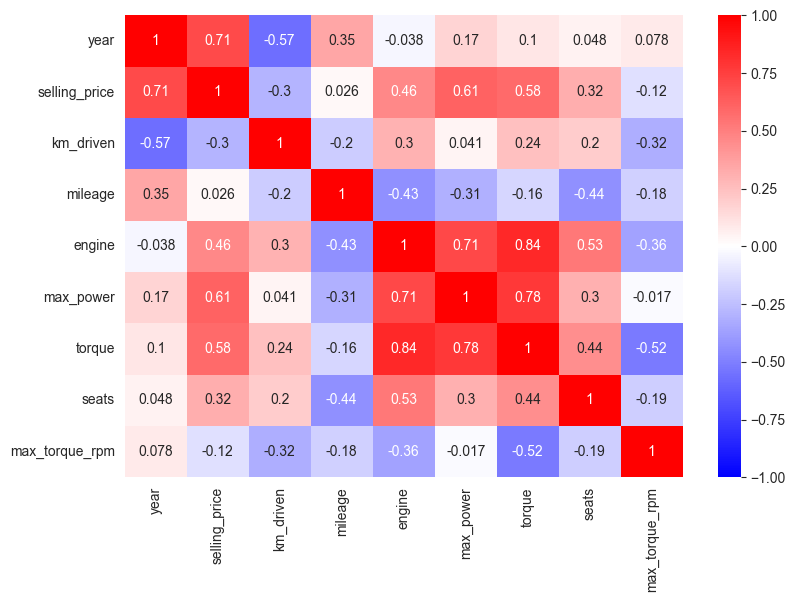

In [22]:
# Библиотечная реализация
spearman_corr = df_train.corr(method="spearman", numeric_only=True)

plt.figure(figsize=(9, 6))
sns.heatmap(spearman_corr, annot=True, cmap="bwr", vmin=-1, vmax=1)
plt.show()

In [23]:
# Кастомная реализация

def spearman_corr(a, b):
    # Индексы
    ia = np.argsort(a)
    ib = np.argsort(b)
    # Ранги
    ra = np.argsort(ia) + 1
    rb = np.argsort(ib) + 1
    # Промежуточный расчет
    n = len(a)
    s = np.sum((ra - rb) ** 2)
    # Формула
    return 1 - 6 * s / ( n * (n ** 2 - 1))


columns = df_train.describe().columns
for i in columns:
    for j in columns:
        spearman_manual = round(spearman_corr(df_train[i].values, df_train[j].values), 2)
        print(i, ' / ', j, ' = ', spearman_manual)


year  /  year  =  1.0
year  /  selling_price  =  0.71
year  /  km_driven  =  -0.57
year  /  mileage  =  0.34
year  /  engine  =  -0.04
year  /  max_power  =  0.17
year  /  torque  =  0.1
year  /  seats  =  0.02
year  /  max_torque_rpm  =  0.08
selling_price  /  year  =  0.71
selling_price  /  selling_price  =  1.0
selling_price  /  km_driven  =  -0.3
selling_price  /  mileage  =  0.03
selling_price  /  engine  =  0.46
selling_price  /  max_power  =  0.61
selling_price  /  torque  =  0.58
selling_price  /  seats  =  0.21
selling_price  /  max_torque_rpm  =  -0.12
km_driven  /  year  =  -0.57
km_driven  /  selling_price  =  -0.3
km_driven  /  km_driven  =  1.0
km_driven  /  mileage  =  -0.2
km_driven  /  engine  =  0.3
km_driven  /  max_power  =  0.04
km_driven  /  torque  =  0.24
km_driven  /  seats  =  0.16
km_driven  /  max_torque_rpm  =  -0.31
mileage  /  year  =  0.34
mileage  /  selling_price  =  0.03
mileage  /  km_driven  =  -0.2
mileage  /  mileage  =  1.0
mileage  /  engine  = 

**Выводы**
- Моя реализация показала такие же результаты, что и библиотека, только работала долльше.
- Если наложить тепловую карту Спирмена на карту пирсона, можно заметить, что цвета ячеек практически совпадают.

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


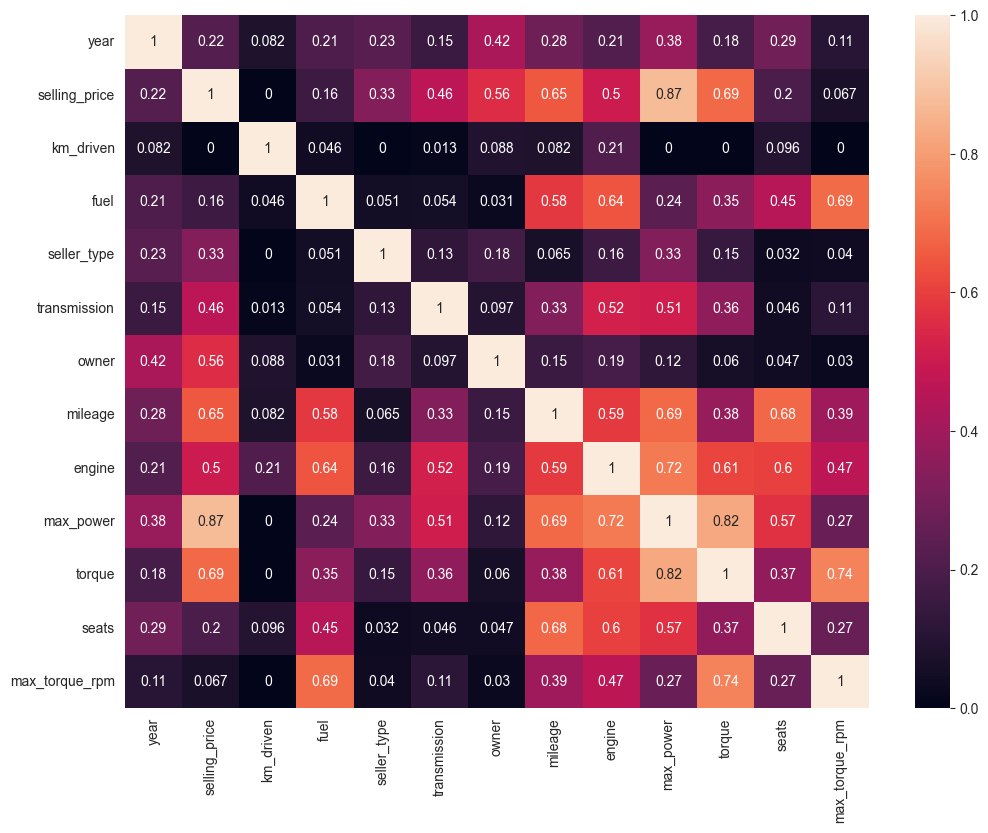

In [24]:
# Phik - любые взаимосвязи

plt.figure(figsize=(12, 9))
df_phik = df_train.drop(columns=['name']) # убрать предупреждение о не категориальном признаке

phik_corr = df_phik.phik_matrix()

sns.heatmap(phik_corr, annot=True)
plt.show()

**Выводы**
- Phik еще раз показал наличие найденных ранее зависимостей.
- Карта дополнилась категориальными фичами. Phik умеет работать с разными типами фичей.
- Видно, что пробег и цена получились 0. Можно подметить, что в полученном ранее pairplot идет кучкование в угол, и возможно phik не сумел корректно забинить фичи.

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

<Axes: >

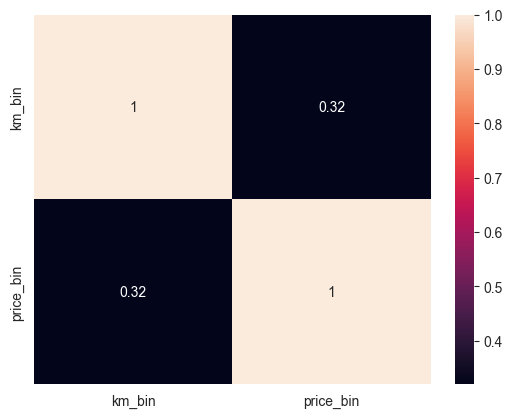

In [25]:
# Покажем, что если руками разбить цену и пробег на бины, то получим нормальный результат

df_check = df_train[['km_driven', 'selling_price']].copy().copy()
df_check['km_bin'] = pd.qcut(df_train['km_driven'], q=12)
df_check['price_bin'] = pd.qcut(df_train['selling_price'], q=12)

phik_corr = df_check[['km_bin', 'price_bin']].phik_matrix()
sns.heatmap(phik_corr, annot=True)


<Figure size 600x400 with 0 Axes>

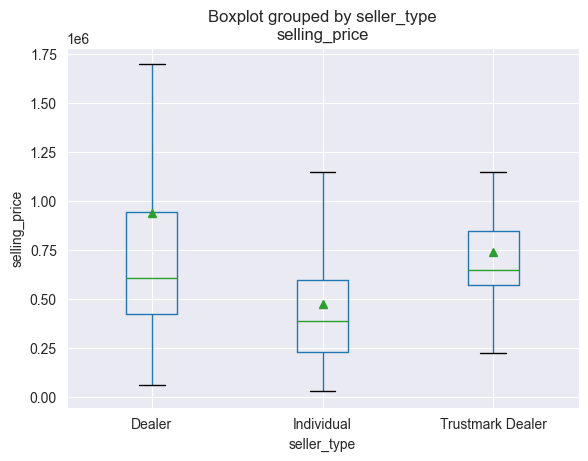

<Figure size 600x400 with 0 Axes>

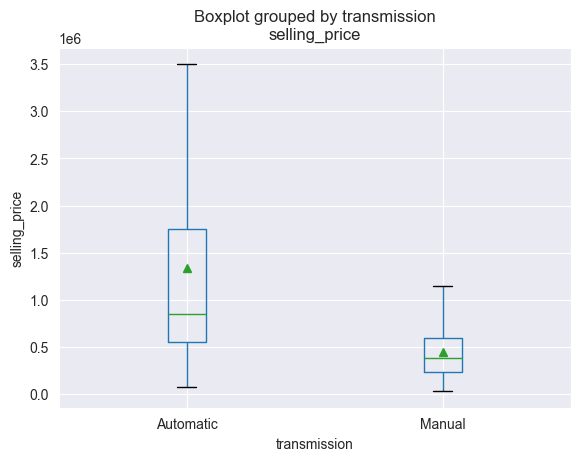

In [26]:
# Boxplot по типам продавцов. Частники продают дешевле.

plt.figure(figsize=(6, 4))
df_train.boxplot(column="selling_price", by="seller_type", showfliers=False, showmeans=True)
plt.ylabel("selling_price")
plt.show()

# Boxplot по типам двигателя. Механика значительно дешевле.

plt.figure(figsize=(6, 4))
df_train.boxplot(column="selling_price", by="transmission", showfliers=False, showmeans=True)
plt.ylabel("selling_price")
plt.show()



# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Сделайте тренировочный и тестовый наборы. Она уже даны, достаточно просто отделить целевой признак. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных. Используйте уже имеющиеся данные train и test. Если считаете уместным применить какую-то более хитрую технику разбиения — примените, но опишите, зачем.

In [27]:
X_train = df_train[df_train.describe(include=['int64', 'float64']).columns.drop('selling_price')].copy()
y_train = df_train['selling_price'].copy()

In [28]:
X_train

,year,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
0,2014,145500,23.40,1248,74.00,190.000,5,2000.0
1,2014,120000,21.14,1498,103.52,250.000,5,2500.0
2,2010,127000,23.00,1396,90.00,219.744,5,2750.0
3,2007,120000,16.10,1298,88.20,112.815,5,4500.0
4,2017,45000,20.14,1197,81.86,113.750,5,4000.0
...,...,...,...,...,...,...,...,...
5835,2008,191000,17.92,1086,62.10,96.100,5,3000.0
5836,2013,50000,18.90,998,67.10,90.000,5,3500.0
5837,2013,110000,18.50,1197,82.85,113.700,5,4000.0
5838,2007,119000,16.80,1493,110.00,235.440,5,2750.0


In [29]:
y_train

0       450000
1       370000
2       225000
3       130000
4       440000
         ...  
5835    120000
5836    260000
5837    320000
5838    135000
5839    382000
Name: selling_price, Length: 5840, dtype: int64

In [30]:
X_test = df_test[df_test.describe(include=['int64', 'float64']).columns.drop('selling_price')].copy()
y_test = df_test['selling_price'].copy()

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [31]:
# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Расчет метрик
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

print('R2 TRAIN: ', r2_train)
print('R2 TEST: ', r2_test)
print('MSE TRAIN: ', mse_train)
print('MSE TEST: ', mse_test)
print('RMSE TRAIN: ', mse_train**0.5)
print('RMSE TEST: ', mse_test**0.5)

R2 TRAIN:  0.6011708139867096
R2 TEST:  0.600654091032351
MSE TRAIN:  114319735167.478
MSE TEST:  229555432051.99536
RMSE TRAIN:  338112.0157099981
RMSE TEST:  479119.43401619117


**Выводы**
- Модель отработала на тесте почти так же как на трейне. Значение R2 - среднее.
- Нет переобучения.
- Большая MSE. Выбросы с огромными значениями цен могли на это напрямую повлиять.

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [32]:
def r2_custom(y_real, y_pred):
    # Приведем всё в numpy массив для удобства расчета
    y_real = np.array(y_real)
    y_pred = np.array(y_pred)
    # Считаем сумму квадратов ошибок модели (на сколько сильно модель ошибается)
    SE_sum = np.sum((y_pred - y_real) ** 2)
    # Считаем среднее по всем имеющимся значениям целевой переменной
    y_mean = y_real.mean()
    # Считаем сумму квадратов отклонений от среднего (разброс данных)
    ME_sum = np.sum((y_real - y_mean) ** 2)
    # Итоговая формула
    return 1 - float(SE_sum / ME_sum)

print('R2 TRAIN: ', r2_custom(y_train, y_pred_train))
print('R2 TEST: ', r2_custom(y_test, y_pred_test))

R2 TRAIN:  0.6011708139867096
R2 TEST:  0.600654091032351


Описал компоненты, а в качестве формулу взял такую из лекции:

$R^2(a, X) = 1 - \frac{\sum_{i=1}^{\ell} (a(x_i) - y_i)^2}{\sum_{i=1}^{\ell} (y_i - \bar{y})^2}$

, где $\bar{y} = \frac{1}{\ell} \sum_{i=1}^{\ell} y_i$

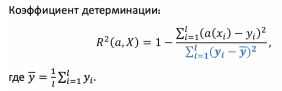

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [33]:
def r2_adjusted(y_real, y_pred, p):
    # Обычный R2
    r2 = r2_score(y_real, y_pred)
    # Количество объектов
    n = len(y_real)
    # p - Количество фичей
    return 1 - (1 - r2) * (n - 1) / (n - p -1)

print('adjusted-R2 TRAIN: ', r2_adjusted(y_train, y_pred_train, X_train.shape[1]))
print('adjusted-R2 TEST: ', r2_adjusted(y_test, y_pred_test, X_test.shape[1]))

adjusted-R2 TRAIN:  0.6006236293720455
adjusted-R2 TEST:  0.5974303097288786


Формулу взял с Вики

$R_{adj}^2 = 1 - (1 - R^2)\,\frac{n - 1}{n - p - 1}$

Штрафует модель за увеличение числа признаков.
Можно применять для сравнения моделей с разным количеством фичей.
Полезно при отборе фичей.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [34]:
scaler = StandardScaler()

# Стандартизатор обучаем только на train
scaler.fit(X_train)

# Собираем стандартизированные данные
X_scale_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_scale_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Проверка: mean = 0, std = 1
X_scale_train.describe()

,year,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03
mean,2.328122e-14,-6.205082e-17,-9.283290e-16,-1.301851e-16,3.485796e-16,1.095014e-16,2.640202e-16,-7.300097e-18
std,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00
min,-7.430137e+00,-1.231167e+00,-4.875222e+00,-1.658595e+00,-2.778531e+00,-1.197318e+00,-3.488601e+00,-2.772139e+00
25%,-5.929826e-01,-5.818974e-01,-6.224460e-01,-4.786631e-01,-6.291976e-01,-5.927139e-01,-4.344190e-01,-8.621759e-01
50%,1.395696e-01,-6.579834e-02,-1.526502e-02,-3.736430e-01,-1.911128e-01,-1.423815e-01,-4.344190e-01,-4.362041e-02
75%,8.721218e-01,4.336523e-01,7.198756e-01,1.411615e-01,3.506458e-01,2.324970e-01,-4.344190e-01,1.047787e+00
max,1.604674e+00,3.806654e+01,5.662630e+00,4.477875e+00,9.864609e+00,1.577715e+01,8.728126e+00,2.047484e+01


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [35]:
# Обучим модель на тренировочном наборе данных с нормализованными признаками
model_scale = LinearRegression()
model_scale.fit(X_scale_train, y_train)

# Какими получились коэффициенты
factors = pd.Series(model_scale.coef_, index=X_scale_train.columns)

print(factors)

year              165487.649069
km_driven         -48759.703210
mileage            -8280.718070
engine             23261.626909
max_power         332409.160109
torque              2259.697195
seats             -29702.898994
max_torque_rpm    -60160.841991
dtype: float64


- Наиболее важным признаком оказалась максимальная мощность - max_power

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [36]:
model_l1 = Lasso(alpha=1)
model_l1.fit(X_scale_train, y_train)

y_pred_l1_train = model_l1.predict(X_scale_train)
y_pred_l1_test = model_l1.predict(X_scale_test)

# Расчет метрик
r2_l1_train = r2_score(y_train, y_pred_l1_train)
r2_l1_test = r2_score(y_test, y_pred_l1_test)
mse_l1_train = MSE(y_train, y_pred_l1_train)
mse_l1_test = MSE(y_test, y_pred_test)

print('R2 TRAIN: ', r2_l1_train)
print('R2 TEST: ', r2_l1_test)
print('MSE TRAIN: ', mse_l1_train)
print('MSE TEST: ', mse_l1_test)
print('RMSE TRAIN: ', mse_l1_train**0.5)
print('RMSE TEST: ', mse_l1_test**0.5, '\n')

model_l1.coef_

R2 TRAIN:  0.6011708139392453
R2 TEST:  0.6006528433430968
MSE TRAIN:  114319735181.08311
MSE TEST:  229555432051.99536
RMSE TRAIN:  338112.01573011733
RMSE TEST:  479119.43401619117 



array([165485.4469187 , -48758.76634462,  -8277.43016844,  23259.61467598,
       332410.55695355,   2259.04400589, -29698.9254389 , -60158.76854111])

- Качество получилось схожее с LinearRegression, обученной на ненормализированных признаках
- Никакие веса не занулились. Каждая числовая фича связана с ценой. Шумовых признаков нет.
- Подбирая alpha, не удалось сделать, чтобы модель как-то улучшила свое качество или избавилась от какого-нибудь признака.

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearchCV`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [37]:
model_lasso = Lasso()

param_grid = {
    "alpha": [0.1, 1, 5, 10, 50, 100, 200, 300, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
    "selection": ["cyclic", "random"],
    "tol": [0.1, 0.01, 0.001, 0.0001],
    "random_state": [42],
}

gs = GridSearchCV(model_lasso, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=2)

gs.fit(X_scale_train, y_train)

# Лучшие параметры
gs.best_params_

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.1; total time=   0.0s
[CV] END alpha=0.1, random_state=42, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.1, r

{'alpha': 2000, 'random_state': 42, 'selection': 'random', 'tol': 0.1}

In [38]:
# Проверка весов
model_l1_gs = Lasso(alpha=2000, selection='random', tol=0.1, random_state=42)
model_l1_gs.fit(X_scale_train, y_train)

# Какими получились коэффициенты
factors = pd.Series(model_l1_gs.coef_, index=X_scale_train.columns)
print(factors)

year              162455.998977
km_driven         -45067.133137
mileage            -7936.451172
engine                -0.000000
max_power         344152.478392
torque                 0.000000
seats             -15062.608514
max_torque_rpm    -60232.132268
dtype: float64


- Обучилось 20 * 2 * 4 * 1 = 1600 моделей

- В param_grid использовал следующие параметры:

        "alpha" - Коэффициент L1 регуляризации.
        "selection" - Алгоритм выбора координаты. "cyclic" — перебор коэффициентов по кругу, "random" — случайный выбор коэффициентов.
        "tol" - Порог сходимости. Чем меньше, тем точнее, но дольше обучение.
        "random_state" - Какое-то число для повторения результатов рандомности.

- GridSearchCV подбирает не просто лучшие параметры. Если качество получается на одном уровне при каких-то параметрах, он выбирает из этих параметров такие, при которых модель обучается быстрее.

- Занулились "engine" и "torque"! Ранее они были с маленькими весами.

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [39]:
elastic_net = ElasticNet(random_state=42)

param_grid = {
    "alpha": [0.1, 1, 5, 10, 50, 100, 200, 300, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],  # 1.0 = Lasso, 0 = Ridge
    "selection": ["cyclic", "random"],
    "tol": [0.1, 0.01, 0.001, 0.0001],
    "random_state": [42],
}

gs = GridSearchCV(elastic_net, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)

gs.fit(X_scale_train, y_train)

# Лучшие параметры
gs.best_params_

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


{'alpha': 2000,
 'l1_ratio': 1.0,
 'random_state': 42,
 'selection': 'random',
 'tol': 0.1}

- Обучилось 20 * 6 * 2 * 4 * 1 = 9600 моделей

- Параметры подобрались как и в предыдущем варианте, т.е. без L2 регуляризации.

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [40]:
# В силу своего начального уровня в Python позвал на помощь ChatGpt.
# Получилась такая модель линейной регрессии с L0-регуляризацией

class L0LinearRegression:
    """
    Linear Regression with L0 regularization (Iterative Hard Thresholding).
    L0 term is approximated via hard thresholding of weights.
    """

    def __init__(self, threshold=0.1, lr=0.001, n_iter=2000):
        """
        threshold — порог для зануления весов (аналог силы регуляризации)
        lr — шаг градиентного спуска
        n_iter — количество итераций
        """
        self.threshold = threshold
        self.lr = lr
        self.n_iter = n_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        """
        Обучение модели градиентным спуском + L0 hard thresholding.
        """
        n, d = X.shape
        self.w = np.zeros(d)
        self.b = 0

        for _ in range(self.n_iter):
            # ---- Gradient Descent step ----
            y_pred = X @ self.w + self.b
            error = y_pred - y

            grad_w = (2/n) * X.T @ error
            grad_b = (2/n) * np.sum(error)

            # Gradient step
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            # L0 thresholding
            self.w = np.where(np.abs(self.w) < self.threshold, 0, self.w)

        return self

    def predict(self, X):
        """
        Предсказание модели.
        """
        return np.array(X) @ self.w + self.b

    def get_params(self, deep=True):
        return {
            "threshold": self.threshold,
            "lr": self.lr,
            "n_iter": self.n_iter
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self


# Обучение модели
model_l0 = L0LinearRegression()
model_l0.fit(X_scale_train, y_train)

y_pred_l0_train = model_l0.predict(X_scale_train)
y_pred_l0_test = model_l0.predict(X_scale_test)

# Расчет метрик
r2_l0_train = r2_score(y_train, y_pred_l0_train)
r2_l0_test = r2_score(y_test, y_pred_l0_test)
mse_l0_train = MSE(y_train, y_pred_l0_train)
mse_l0_test = MSE(y_test, y_pred_l0_test)

print('R2 TRAIN: ', r2_l0_train)
print('R2 TEST: ', r2_l0_test)
print('MSE TRAIN: ', mse_l0_train)
print('MSE TEST: ', mse_l0_test)
print('RMSE TRAIN: ', mse_l0_train**0.5)
print('RMSE TEST: ', mse_l0_test**0.5, '\n')

# Веса
model_l0.w


R2 TRAIN:  0.5947762824850393
R2 TEST:  0.5835046567238819
MSE TRAIN:  116152653051.69392
MSE TEST:  239413416605.54907
RMSE TRAIN:  340811.7560350493
RMSE TEST:  489298.903131357 



array([163602.91768644, -56003.69543097,   4956.60160231,  70705.56131108,
       268250.81863608,  42147.7044493 , -42610.52576062, -35193.95390731])

Чтобы поэкспериментировать с коэффициентом регуляризации в текущей реализации L0-регрессии, нужно менять параметр threshold.
Это гиперпараметр, управляющий силой L0-штрафа:
- маленький threshold → слабая регуляризация → почти ничего не зануляется
- большой threshold → сильная регуляризация → много признаков зануляется
- очень большой threshold → модель выкинет почти все признаки

In [41]:
param_grid = {
    "threshold": [0.001, 0.01, 0.05, 0.1, 0.3],
    "lr": [0.001, 0.005, 0.01],
    "n_iter": [2000, 4000]
}

gs = GridSearchCV(model_l0, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=3)

gs.fit(X_scale_train, y_train)

# Лучшие параметры
gs.best_params_

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10] END lr=0.001, n_iter=2000, threshold=0.001;, score=-323845312552.139 total time=   0.0s
[CV 2/10] END lr=0.001, n_iter=2000, threshold=0.001;, score=-71517265090.592 total time=   0.0s
[CV 3/10] END lr=0.001, n_iter=2000, threshold=0.001;, score=-88032910693.889 total time=   0.0s
[CV 4/10] END lr=0.001, n_iter=2000, threshold=0.001;, score=-97461503530.523 total time=   0.0s
[CV 5/10] END lr=0.001, n_iter=2000, threshold=0.001;, score=-75204668519.380 total time=   0.0s
[CV 6/10] END lr=0.001, n_iter=2000, threshold=0.001;, score=-112850063456.426 total time=   0.0s
[CV 7/10] END lr=0.001, n_iter=2000, threshold=0.001;, score=-190907464222.132 total time=   0.0s
[CV 8/10] END lr=0.001, n_iter=2000, threshold=0.001;, score=-75767040952.943 total time=   0.0s
[CV 9/10] END lr=0.001, n_iter=2000, threshold=0.001;, score=-53492760068.269 total time=   0.0s
[CV 10/10] END lr=0.001, n_iter=2000, threshold=0.001;, score

{'lr': 0.005, 'n_iter': 2000, 'threshold': 0.001}

In [42]:
# Проверяем модель с лучшими параметрами
model_l0_gs = L0LinearRegression(threshold=0.001, lr=0.005, n_iter=2000)
model_l0_gs.fit(X_scale_train, y_train)

y_pred_l0_train = model_l0_gs.predict(X_scale_train)
y_pred_l0_test = model_l0_gs.predict(X_scale_test)

r2_l0_train = r2_score(y_train, y_pred_l0_train)
r2_l0_test = r2_score(y_test, y_pred_l0_test)
mse_l0_train = MSE(y_train, y_pred_l0_train)
mse_l0_test = MSE(y_test, y_pred_l0_test)

print('R2 TRAIN: ', r2_l0_train)
print('R2 TEST: ', r2_l0_test)
print('MSE TRAIN: ', mse_l0_train)
print('MSE TEST: ', mse_l0_test)
print('RMSE TRAIN: ', mse_l0_train**0.5)
print('RMSE TEST: ', mse_l0_test**0.5, '\n')

R2 TRAIN:  0.6011364025062025
R2 TEST:  0.6003249566524971
MSE TRAIN:  114329598817.07101
MSE TEST:  229744627892.17776
RMSE TRAIN:  338126.60175897286
RMSE TEST:  479316.8345595403 



**Качество улучшилось!**

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [43]:
def purify(name):
    words = re.sub(r"[^A-Za-z0-9]+", " ", name).split() # разбиваем на списки слов
    list = []
    for word in words:
        if re.search(r"[A-Za-z]", word): # хотя бы 1 буква
            list.append(word)
        if len(list) == 2: # не больше чем бренд + модель
            break
    if len(list) == 1:
        list.append(None)
    return list

# Чтобы уменьшить множество категорий в name, преобразуем название в бренд + модель, остальное выкидываем
df_train[['brand', 'name']] = df_train['name'].apply(lambda x: pd.Series(purify(x)))
df_test[['brand', 'name']] = df_test['name'].apply(lambda x: pd.Series(purify(x)))

df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm,brand
0,Swift,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.000,5,2000.0,Maruti
1,Rapid,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.000,5,2500.0,Skoda
2,i20,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,219.744,5,2750.0,Hyundai
3,Swift,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,112.815,5,4500.0,Maruti
4,Xcent,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.750,5,4000.0,Hyundai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Santro,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086,62.10,96.100,5,3000.0,Hyundai
5836,Wagon,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998,67.10,90.000,5,3500.0,Maruti
5837,i20,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197,82.85,113.700,5,4000.0,Hyundai
5838,Verna,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493,110.00,235.440,5,2750.0,Hyundai


In [44]:
X_train_cat = df_train[df_train.columns.drop(['selling_price'])].copy()
X_test_cat = df_test[df_test.columns.drop(['selling_price'])].copy()

X_train_cat.describe(include='object')

,name,fuel,seller_type,transmission,owner,brand
count,5840,5840,5840,5840,5840,5840
unique,195,4,3,2,5,30
top,Swift,Diesel,Individual,Manual,First Owner,Maruti
freq,558,3177,5223,5336,3603,1804


### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [45]:
warnings.filterwarnings("ignore", message="Found unknown categories")

for col in ["seats", "name", "fuel", "seller_type", "transmission", "owner", "brand"]:
    # OneHotEncoder
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    # OneHotEncoder обучаем только на train
    train_transformed = ohe.fit_transform(X_train_cat[[col]])

    # Для test
    test_transformed = ohe.transform(X_test_cat[[col]])

    # Преобразуем в DataFrame
    df_tr_train = pd.DataFrame(train_transformed, index=X_train_cat.index, columns=ohe.get_feature_names_out([col]))
    df_tr_test = pd.DataFrame(test_transformed, index=X_test_cat.index, columns=ohe.get_feature_names_out([col]))

    # Собираем вместе
    X_train_cat = pd.concat([X_train_cat.drop(columns=[col]), df_tr_train], axis=1)
    X_test_cat = pd.concat([X_test_cat.drop(columns=[col]), df_tr_test], axis=1)

X_train_cat.describe()

,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,seats_4,seats_5,seats_6,...,brand_Mercedes,brand_Mitsubishi,brand_Nissan,brand_Peugeot,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo
count,5840.000000,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,7.395224e+04,19.430841,1429.448973,87.906371,175.239377,3039.967123,0.016096,0.790753,0.008219,...,0.007534,0.001370,0.010788,0.000171,0.029281,0.010445,0.091438,0.052911,0.026199,0.001370
std,4.095622,6.007114e+04,3.985973,485.662834,31.640418,107.041196,916.326648,0.125855,0.406806,0.090294,...,0.086480,0.036989,0.103311,0.013086,0.168607,0.101675,0.288256,0.223875,0.159739,0.036989
min,1983.000000,1.000000e+00,0.000000,624.000000,0.000000,47.088000,500.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,3.900000e+04,16.950000,1197.000000,68.000000,111.800000,2250.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.000000,7.000000e+04,19.370000,1248.000000,81.860000,160.000000,3000.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,1.000000e+05,22.300000,1498.000000,99.000000,200.124000,4000.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,2.360457e+06,42.000000,3604.000000,400.000000,1863.900000,21800.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

**Ответы:**
- Как было показано в коде - обучаем OHE на train, а применяем преобразование после к test через transform
- Удалили один столбец, чтобы уйти от линейной зависимости столбцов.
- Если коэффициенты у признаков близки к нулю, то можно удалить, или за нас это же может сделать L1 регуляризация.

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [51]:
model_ridge = Ridge()

param_grid = {
    "alpha": [0.05, 0.1, 1, 5, 10, 50, 100, 200, 500],
    "tol": [0.1, 0.01, 0.001],
}

gs = GridSearchCV(model_ridge, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=3)

gs.fit(X_train_cat, y_train)

# Лучшие параметры
gs.best_params_


Fitting 10 folds for each of 27 candidates, totalling 270 fits
[CV 1/10] END ..alpha=0.05, tol=0.1;, score=-172182268225.386 total time=   0.0s
[CV 2/10] END ...alpha=0.05, tol=0.1;, score=-32448933090.774 total time=   0.0s
[CV 3/10] END ...alpha=0.05, tol=0.1;, score=-56621061849.152 total time=   0.0s
[CV 4/10] END ...alpha=0.05, tol=0.1;, score=-57437327729.671 total time=   0.0s
[CV 5/10] END ...alpha=0.05, tol=0.1;, score=-45590970508.990 total time=   0.0s
[CV 6/10] END ...alpha=0.05, tol=0.1;, score=-59557827253.819 total time=   0.0s
[CV 7/10] END ..alpha=0.05, tol=0.1;, score=-105122900376.564 total time=   0.0s
[CV 8/10] END ...alpha=0.05, tol=0.1;, score=-62709544558.786 total time=   0.0s
[CV 9/10] END ...alpha=0.05, tol=0.1;, score=-27067476290.848 total time=   0.0s
[CV 10/10] END ..alpha=0.05, tol=0.1;, score=-60352962176.009 total time=   0.0s
[CV 1/10] END .alpha=0.05, tol=0.01;, score=-172182268225.386 total time=   0.0s
[CV 2/10] END ..alpha=0.05, tol=0.01;, score=-

{'alpha': 0.1, 'tol': 0.1}

In [61]:
# Проверяем модель с лучшими параметрами
model_l2_gs = Ridge(alpha=0.1, tol=0.1)
model_l2_gs.fit(X_train_cat, y_train)

y_pred_l2_train = model_l2_gs.predict(X_train_cat)
y_pred_l2_test = model_l2_gs.predict(X_test_cat)

r2_l2_train = r2_score(y_train, y_pred_l2_train)
r2_l2_test = r2_score(y_test, y_pred_l2_test)
mse_l2_train = MSE(y_train, y_pred_l2_train)
mse_l2_test = MSE(y_test, y_pred_l2_test)

print('R2 TRAIN: ', r2_l2_train)
print('R2 TEST: ', r2_l2_test)
print('MSE TRAIN: ', mse_l2_train)
print('MSE TEST: ', mse_l2_test)
print('RMSE TRAIN: ', mse_l2_train**0.5)
print('RMSE TEST: ', mse_l2_test**0.5, '\n')


R2 TRAIN:  0.8605046362756282
R2 TEST:  0.881719440469439
MSE TRAIN:  39984719266.58294
MSE TEST:  67991043195.05945
RMSE TRAIN:  199961.79451731007
RMSE TEST:  260750.92175303897 



**Итог:**
- Добавление новых категориальных признаков позволило составить более точную модель. Метрики значительно улучшились.

In [63]:
# Pickle

data = {
    "linear_base": {
        "name": "LinearRegression",
        "model": model,
        "features": X_train.columns.tolist(),
    },
    "linear_scaled": {
        "name": "LinearRegression + StandardScaler",
        "model": model_scale,
        "scaler": scaler,
        "features": X_scale_train.columns.tolist(),
    },
    "lasso_scaled": {
        "name": "Lasso + StandardScaler",
        "model": model_l1,
        "scaler": scaler,
        "features": X_scale_train.columns.tolist(),
    },
    "lasso_scaled_gs": {
        "name": "Lasso + StandardScaler + GridSearch",
        "model": model_l1_gs,
        "scaler": scaler,
        "features": X_scale_train.columns.tolist(),
    },
    "l0_scaled": {
        "name": "L0 + StandardScaler",
        "model": model_l0,
        "scaler": scaler,
        "features": X_scale_train.columns.tolist(),
    },
    "l0_scaled_gs": {
        "name": "L0 + StandardScaler + GridSearch",
        "model": model_l0_gs,
        "scaler": scaler,
        "features": X_scale_train.columns.tolist(),
    },
    "ridge_scaled_gs": {
        "name": "Ridge + StandardScaler + GridSearch",
        "model": model_l2_gs,
        "scaler": scaler,
        "features": X_train_cat.columns.tolist(),
    },
}

with open("models.pkl", "wb") as f:
    pickle.dump(data, f)

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [46]:
# your code here

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [47]:
def business_metrics(y_true, y_pred):
    # your code here

business_metrics(# your code here)

IndentationError: expected an indented block after function definition on line 1 (2498205373.py, line 4)

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [ ]:
def your_business_metrics(y_true, y_pred):

business_metrics(# your code here)

# **<font color="green">Часть 5 | Создание интерактивного приложения на Streamlit (3 балла)</font>**

Вам необходимо создать интерактивное приложение на Streamlit, которое будет:

- Показывать основные информативные графики/гистограммы в рамках EDA (1 балл)
- На вход запрашивать csv-файл с признаками объектов или запрашивать признаки объекта в окошках для ввода, и применять на поступивших объектах модель (1 балл)
- Визуализировать веса обученной модели (1 балл)

# **Часть 6 | Оформление репозитория и оценка сервиса (3 балла)**

**Результаты вашей работы** необходимо разместить в своём GitHub-репозитории. В этот же репозиторий позже будет добавлена вторая часть.

Под результатами первой части понимаем следующее:

---

### Обязательные файлы:

1. **`.ipynb`-ноутбук** со всеми экспериментами:

   * полный EDA,
   * все шаги препроцессинга,
   * обучение и сравнение моделей,
   * сохранённые output’ы.

2. **`.pickle`-файл**, содержащий:

   * обученную модель (или пайплайн `scaler + model`);
   * параметры скейлинга;
   * любые числовые объекты, необходимые для инференса внутри Streamlit-приложения.

3. **`.md`-файл с выводами** о проделанной работе:

   * что было сделано (краткое описание каждого этапа);
   * какие результаты были получены (метрики + интерпретация);
   * что дало наибольший прирост качества;
   * что сделать не удалось и почему (это нормально и даже полезно);
   * **оценка разработанного сервиса**:

     * насколько приложение удобно в использовании;
     * что получилось визуализировать хорошо, а что — менее удачно;
     * какие ограничения или проблемы вы заметили;
     * какие улучшения планируете в следующей итерации.

По результатам второй части, ждем:

4. **Streamlit-приложение** (например, `app.py`), которое можно запустить командой:

   ```bash
   streamlit run app.py
   ```

В приложении должно быть:

* отображение ключевых графиков EDA;
* ввод данных (CSV или ручной ввод);
* применение модели;
* визуализация весов/коэффициентов.

**И ссылку на приложение в StreamlitHub.**


### **За что могут быть сняты баллы:**

* отсутствие `.pickle` с моделью / пайплайном;
* слабая или неполная аналитика в `.md`-файле;
* беспорядок в ноутбуке или неясная логика вычислений;
* отсутствие возможности запустить Streamlit-приложение.
